In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm_notebook

plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

# Task 1

Solve the Poisson equation on the grid:

$$ \frac{d^2}{dr^2}U(r) = - 4 \pi r n_s(r) $$
where $n_s(r) = |\phi(r)|^2$ is the density and $U(r) = r V_H(r)$. The equation can then be written as:

$$ \frac{d^2}{dr^2}U(r) = - 4 \pi rn_s(r) $$

Space is discretized as 

$$ r_i = 0+ih \hspace{10px} i=0,...,n, \hspace{10px} h = r_{max}/n $$
which leads to 
$$ U''(r_i) = \frac{U(r_{i+1})-2U(r_i) + U(r_{i-1})}{h^2}$$

Thus our equation becomes:

$$ U(r_{i+1})-2U(r_i) + U(r_{i-1})  = - 4 \pi h^2 |\phi(r_i)|^2 r_i $$

Writing this on matrix form with the vectors for U and the density times r, $\eta$:

\begin{equation}
    U = 
    \begin{bmatrix}
        U(r_0) \\
        U(r_1) \\
        U(r_2) \\
        ... \\
    \end{bmatrix}
\end{equation}

\begin{equation}
    \eta = 
    \begin{bmatrix}
        \eta(r_0) = - 4 \pi h^2 |\phi(r_0)|^2 r_0 \\
        \eta(r_1) \\
        \eta(r_2) \\
        ... \\
    \end{bmatrix}
\end{equation}

The $U$ vectors is of length $N+2$ and $\eta$ is of length $N$, with the two endterms encoding are boundary conditions: U(0)=0, U(inf)=1. phi can be evaluated as a function. The final matrix is thus Nx(N+2) for our N ordinary equations. The first few rows are:

\begin{equation}
    A' = 
    \begin{bmatrix}
        1 & -2 & 1 & 0 & 0 & 0 \\
        0 & 1 & -2 & 1 & 0 & 0 \\
        0 & 0 & 1 & -2 & 1 & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

Note that it is not (N+2)x(N+2) since the two equations centered around our endpoints doesn't exist. We rewrite this as an NxN matrix by moving in the i=0 and i=N+1 terms. We then get the NxN matrix A':

\begin{equation}
    A = 
    \begin{bmatrix}
        -2 & 1 & 0 & 0 & 0 \\
         1 & -2 & 1 & 0 & 0 \\
         0 & 1 & -2 & 1 & 0 \\
        ... \\
    \end{bmatrix}
\end{equation}

and 

\begin{equation}
    \eta = 
    \begin{bmatrix}
        \eta(r_0) = - 4 \pi h^2 |\phi(r_0)|^2 r_0 - 0\\
        \eta(r_1) \\
        \eta(r_2) \\
        ... \\
    \end{bmatrix}
\end{equation}

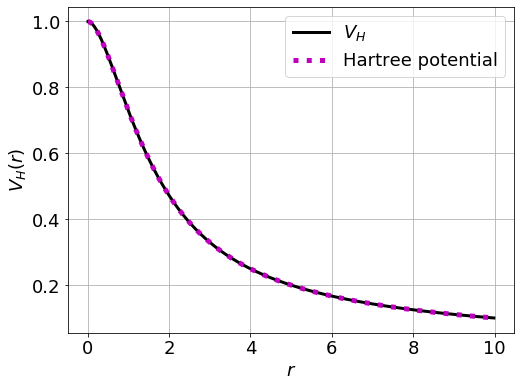

In [47]:
def phi(r):
    '''Electron ground state function'''
    return 1/np.sqrt(np.pi) * np.exp(-r)

def Hart_pot(r):
    return 1/r - (1+1/r)*np.exp(-2*r)


N = 1000
r_inf = 10
h = r_inf/(N+2)
r = np.array([h*i for i in range(1,N+1)])
eta = -4*np.pi*r*h**2*phi(r)**2
# Boundary conditions
eta[0] -= 0
eta[-1] -= 1

A = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if(i==j):
            A[i,j] = -2
        elif(np.abs(i-j) == 1):
            A[i,j] = 1
        else:
            A[i,j] = 0

# Solve this 
U = np.linalg.solve(A, eta)

# Print solution
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(r, U/r, linewidth=3, c='k', label=r'$V_H$')
ax.plot(r, Hart_pot(r), c='m', linewidth=5, linestyle=':', alpha=1, label='Hartree potential')
ax.grid()
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$V_H(r)$')
ax.legend(loc='best')

# Task 2

Implement the Schrödinger equation in a similar manner as the Poission equation above. We set V_H = 0. We discretize the derivates in f(r), which yields: 

$$ -\frac{1}{2} \frac{f(r_{i-1}) - 2f(r_{i}) + f(r_{i+1})}{h^2} - \frac{2}{r_i}f(r_i) + V_H(r_i)f(r_i) = \epsilon f(r_i) $$

We write this on reduced matrix form as in task 1.

$$ B'f = \epsilon \tilde{f}$$

with B' being the (N)x(N+2) matrix.

\begin{equation}
    B' = 
    \begin{bmatrix}
         -\frac{1}{2h^2} & \frac{1}{h^2} - \frac{2}{r_0} + V_H(r_0) & -\frac{1}{2h^2} & 0 & 0 \\
         0 & -\frac{1}{2h^2} & \frac{1}{h^2} - \frac{2}{r_1} + V_H(r_1) & -\frac{1}{2h^2} & 0 \\
         0 & 0 & -\frac{1}{2h^2} & \frac{1}{h^2} - \frac{2}{r_2} + V_H(r_2) & -\frac{1}{2h^2} \\
        ... \\
    \end{bmatrix}
\end{equation}


$f(r)$ is now a vector of length $N+2$, and \tilde{f}. But since the boundary conditions are $f(0)=0$ and $f(N+1) = 0$, we can implement these boundary conditions in a similar fashion as in task A. Then we can write:

$$ f(0) \hspace{5px} -2 f(1) \hspace{5px} + f(2) = \lambda f(1) == -2 f(1) \hspace{5px} + f(2) = \lambda f(1)-0$$ 

Meaning we can write our matrix as the (NxN) matrix B:

\begin{equation}
    B = 
    \begin{bmatrix}
         \frac{1}{h^2} - \frac{2}{r_1} + V_H(r_1) & -\frac{1}{2h^2} & 0 & 0  \\
         -\frac{1}{2h^2} & \frac{1}{h^2} - \frac{2}{r_2} + V_H(r_2) & -\frac{1}{2h^2} & 0 \\
         0 & -\frac{1}{2h^2} & \frac{1}{h^2} - \frac{2}{r_3} + V_H(r_3) & -\frac{1}{2h^2} \\
        ... \\
    \end{bmatrix}
\end{equation}

and we obtain the eigenvalue equation:

$$ B \tilde{f} = \lambda \tilde{f}$$

For the case of the hydrogen atom, we set V_H = 0 and potential 1/r instead of 2/r. So we get + 2h^2/r.

In [48]:
def wavef(r):
    return 1/np.sqrt(np.pi)*np.exp(-r)

# Define matrix
B = np.zeros((N,N))

for i in tqdm_notebook(range(N)):
    for j in range(N):
        if(i==j):
            B[i,j] = 1/h**2 - 1/r[i]
        elif(np.abs(i-j) == 1):
            B[i,j] = -1/(2*h**2)
        else:
            B[i,j] = 0

# display(B)

/home/eric/miniconda3/envs/physics/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [49]:
# Calculate the eigenvalues
eigs, eigv = np.linalg.eigh(B)
# idx = np.argsort(eigs)

# eigs = eigs[idx]
# eigv = eigv[:,idx]

Epsilon = -0.5000 a.u.


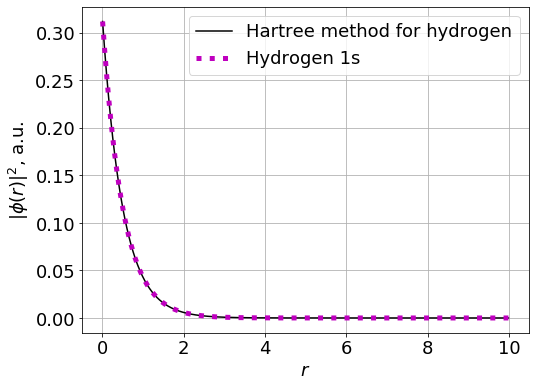

In [57]:
# fig, ax = plt.subplots(figsize=(8,6))
# ax.plot(eigs, linewidth=0, marker='*')

i_e = 0
print(f'Epsilon = {eigs[i_e]:.4f} a.u.')

fig, ax = plt.subplots(figsize=(8,6))

f = eigv[:,i_e]
phi_tilde_sq = ( f/( np.sqrt(4*np.pi)*r ) )**2
norm_phi_tilde_sq = 4*np.pi * np.trapz(r**2 * phi_tilde_sq, r)
norm_phi_sq = phi_tilde_sq / norm_phi_tilde_sq

wav_t = wavef(r)**2

ax.plot(r, norm_phi_sq, c='k', label=r'Hartree method for hydrogen')
ax.plot(r, wav_t, c='m', linewidth=5, linestyle=':', alpha=1, label='Hydrogen 1s')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$|\phi(r)|^2$, a.u.')
ax.grid()
ax.legend(loc='best')
# ax.set_xlim(0,0.2)
# ax.set_ylim(0,0.5)

# Task 3

Now do the self-consistency iteration. We can reuse the matrix, but we have to update the matrix B for each iteration.

In [31]:
def initial_trial_density(r):
    '''Electron ground state wavefunction - squared!'''
    return 1/np.pi * np.exp(-2*r)


N = 1000
r_inf = 10
h = r_inf/(N+2)
r = np.array([h*i for i in range(1,N+1)])

A = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if(i==j):
            A[i,j] = -2
        elif(np.abs(i-j) == 1):
            A[i,j] = 1
        else:
            A[i,j] = 0
B = np.zeros((N,N))
Energies = [0,1]
tol = 1e-5

phi_density = initial_trial_density(r)

while np.abs(Energies[-1]-Energies[-2]) > tol: 
    # Define eta for this iteration
    eta = -4*np.pi*r*h**2*phi_density
    # Boundary conditions
    eta[0] -= 0
    eta[-1] -= 1
    
    # Calculate Hartree potential
    U = np.linalg.solve(A, eta)
    V_H = U/r
    
    # Generate B matrix
    for i in range(N):
        for j in range(N):
            if(i==j):
                B[i,j] = 1/h**2 - 2/r[i] + V_H[i]
            elif(np.abs(i-j) == 1):
                B[i,j] = -1/(2*h**2)
            else:
                B[i,j] = 0
    
    # Calculate eigenvalues and eigenvectors
    eigs, eigv = np.linalg.eigh(B)
    
    # Eigenvalue
    epsilon = eigs[0]
    E = 2*epsilon - 4*np.pi * np.trapz(r**2 * V_H * phi_density, r)
    Energies.append(E)
    
    # Eigenvector
    f_density = eigv[:,0]**2
    phi_tilde_sq =  f_density/(4 * np.pi * r**2)
    norm_phi_tilde_sq = 4*np.pi * np.trapz(r**2 * phi_tilde_sq, r)
    norm_phi_sq = phi_tilde_sq / norm_phi_tilde_sq
    
    # Update phi_density
    phi_density = norm_phi_sq

[0, 1, -3.0130197086084216, -2.8717387015289955, -2.862274306567899, -2.861410910429031, -2.8613383206742506, -2.861331824880423]


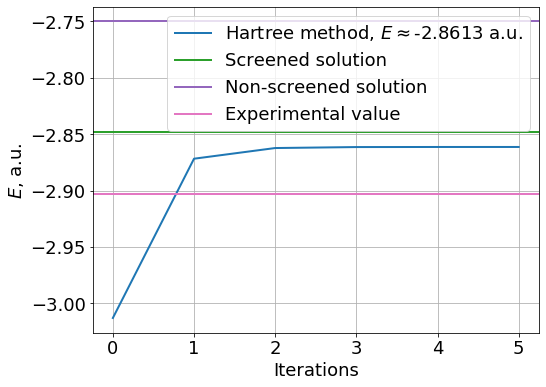

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(Energies[2:], linewidth=2, label=rf'Hartree method, $E\approx${Energies[-1]:.4f} a.u.')
ax.axhline(-2.848, color='C2', linewidth=2, label='Screened solution')
ax.axhline(-2.750, color='C4', linewidth=2, label='Non-screened solution')
ax.axhline(-2.9033, color='C6', linewidth=2, label='Experimental value')
ax.set_xlabel("Iterations")
ax.set_ylabel(r'$E$, a.u.')
ax.grid()
ax.legend(loc='best')
print(Energies)

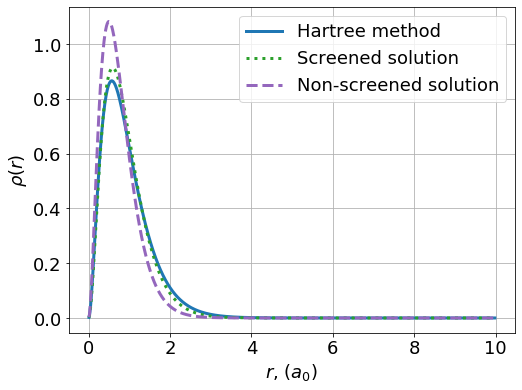

In [45]:
def central_field(r, Z):
    return 4 * r**2 * Z**3 * np.exp(-2*Z*r)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(r, 4*np.pi*r**2 * phi_density, linewidth=3,label=rf'Hartree method')
ax.plot(r, central_field(r, 27/16),  color='C2', linestyle=':',  linewidth=3, label='Screened solution')
ax.plot(r, central_field(r, 2), color='C4', linewidth=3, linestyle='--', label='Non-screened solution')
ax.set_xlabel(r'$r$, $(a_0)$')
ax.set_ylabel(r'$\rho(r)$')
ax.grid()
ax.legend(loc='best')